In [125]:
import sys  
sys.path.insert(0, 'C:\\Users\\espebh\\Documents\\Thesis\\code_ver2')
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
import json
from PIL import Image
import random
import pickle
import matplotlib.pyplot as plt
from helpers import m
import cv2
import sys
from external_code._external_classification.train import train_one_epoch
from helpers.dataset_evaluation import print_class_distribution

In [126]:
test_path_dot = 'C:\\Users\\espebh\\Documents\\Thesis\\data\\semiautomatically generated data\\labled data\\tank 9 data test\\dot_data_balanced'
test_path_RGB = 'C:\\Users\\espebh\\Documents\\Thesis\\data\\semiautomatically generated data\\labled data\\tank 9 data test\\balanced_data'
save_path = 'C:\\Users\\espebh\\Documents\\Thesis\\Report\\conf_matrices'
#train_path = 'C:\\Users\\espebh\\Documents\\Thesis\\data\\semiautomatically generated data\\labelled data\\dot_dataset'

In [127]:
class salmonToraxDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        self.transforms = torchvision.transforms.ToTensor()
        self.imgs = list(sorted(os.listdir(os.path.join(path, 'images'))))
        self.targets = list(sorted(os.listdir(os.path.join(path, 'labels'))))
        self.path = path
        
    def __getitem__(self, idx):
        
        with open(os.path.join(self.path, 'labels', self.targets[idx])) as f:
            label = json.load(f)
        img = Image.open(os.path.join(self.path, 'images', self.imgs[idx]))
        img_tensor = torchvision.transforms.functional.pil_to_tensor(img)
        img_tensor = torch.div(img_tensor, 255)
        img_tensor = img_tensor.to(m.DEVICE)
        return img_tensor, label

    def __len__(self):
        return len(self.imgs)

In [128]:
class salmonToraxDotDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        self.transforms = torchvision.transforms.ToTensor()
        self.imgs = list(sorted(os.listdir(os.path.join(path, 'images_gray'))))
        self.targets = list(sorted(os.listdir(os.path.join(path, 'labels'))))
        self.path = path
        
    def __getitem__(self, idx):
        
        with open(os.path.join(self.path, 'labels', self.targets[idx])) as f:
            label = json.load(f)
        img_gray = cv2.imread(os.path.join(self.path, 'images_gray', self.imgs[idx]))
        img_mask = cv2.imread(os.path.join(self.path, 'images_mask', self.imgs[idx]))
        img_lap = cv2.imread(os.path.join(self.path, 'images_lap', self.imgs[idx]))
        img = np.dstack([img_gray[:,:,0], img_mask[:,:,1], img_lap[:,:,2]])
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img.astype(np.uint8))
        
        img_tensor = torchvision.transforms.functional.pil_to_tensor(img_pil)
        img_tensor = torch.div(img_tensor, 255)
        img_tensor = img_tensor.to(m.DEVICE)
        return img_tensor, label

    def __len__(self):
        return len(self.imgs)

In [129]:
test_dot_dataset = salmonToraxDotDataset(test_path_dot)
test_RGB_dataset = salmonToraxDataset(test_path_RGB)
data_loader_test_dot = torch.utils.data.DataLoader(test_dot_dataset, batch_size=m.BATCH_SIZE, shuffle=True)
data_loader_test_RGB = torch.utils.data.DataLoader(test_RGB_dataset, batch_size=m.BATCH_SIZE, shuffle=True)

In [130]:
mod_name = 'resnet101_RGB_10_epoch'

match mod_name:
    case 'alex_RGB':
        model = torchvision.models.alexnet(pretrained=True)
        model.classifier[6] = nn.Linear(in_features=4096, out_features=m.NUM_CLASSES_T9)
        model.load_state_dict(torch.load('C:\\Users\\espebh\\Documents\\Thesis\\data\\models\\torax_ID_t9\\1000_dataset_2_epoch_RGB_alex', map_location=m.DEVICE))
        data_loader = data_loader_test_RGB
        title = 'Alexnet trained for 2 epochs on color images'
        model.to(m.DEVICE).eval()
    case 'resnet50_RGB':
        model = torchvision.models.resnet50(pretrained=True)
        model.fc = nn.Linear(in_features=2048, out_features=m.NUM_CLASSES_T9)
        model.load_state_dict(torch.load('C:\\Users\\espebh\\Documents\\Thesis\\data\\models\\torax_ID_t9\\1000_dataset_2_epoch_RGB_resnet50', map_location=m.DEVICE))
        data_loader = data_loader_test_RGB
        title = 'Resnet50 trained for 2 epochs on color images'
        model.to(m.DEVICE).eval()
    case 'efficientnet_RGB':
        model = torchvision.models.efficientnet_b3(pretrained=False, pretrained_backbone=True, num_classes = m.NUM_CLASSES_T9)
        model.load_state_dict(torch.load('C:\\Users\\espebh\\Documents\\Thesis\\data\\models\\torax_ID_t9\\1000_dataset_2_epoch_RGB_efficientnet', map_location=m.DEVICE))
        data_loader = data_loader_test_RGB
        title = 'Efficientnet b3 trained for 2 epochs on color images'
        model.to(m.DEVICE).eval()
    case 'resnet50_dot':
        model = torchvision.models.resnet50(pretrained=True)
        model.fc = nn.Linear(in_features=2048, out_features=m.NUM_CLASSES_T9)
        model.load_state_dict(torch.load('C:\\Users\\espebh\\Documents\\Thesis\\data\\models\\torax_ID_t9\\1000_dataset_2_epoch_dot_resnet50', map_location=m.DEVICE))
        data_loader = data_loader_test_dot
        title = 'Resnet50 trained for 2 epochs on dot images'
        model.to(m.DEVICE).eval()
    case 'efficientnet_dot_8_epoch':
        model = torchvision.models.efficientnet_b3(pretrained=False, pretrained_backbone=True, num_classes = m.NUM_CLASSES_T9)
        model.load_state_dict(torch.load('C:\\Users\\espebh\\Documents\\Thesis\\data\\models\\torax_ID_t9\\1000_8_epoch_dot', map_location=m.DEVICE))
        data_loader = data_loader_test_dot
        title = 'Efficientnet b3 trained for 8 epochs on dot images'
        model.to(m.DEVICE).eval()
    case 'resnet101_RGB':
        model = torchvision.models.resnet101(pretrained=True)
        model.fc = nn.Linear(in_features=2048, out_features=m.NUM_CLASSES_T9)
        model.load_state_dict(torch.load('C:\\Users\\espebh\\Documents\\Thesis\\data\\models\\torax_ID_t9\\1000_dataset_2_epoch_RGB_resnet101', map_location=m.DEVICE))
        data_loader = data_loader_test_RGB
        title = 'Resnet101 trained for 2 epochs on color images'
        model.to(m.DEVICE).eval()
    case 'resnet101_RGB_10_epoch':
        model = torchvision.models.resnet101(pretrained=True)
        model.fc = nn.Linear(in_features=2048, out_features=m.NUM_CLASSES_T9)
        model.load_state_dict(torch.load('C:\\Users\\espebh\\Documents\\Thesis\\data\\models\\torax_ID_t9\\1000_dataset_10_epoch_RGB_resnet101', map_location=m.DEVICE))
        data_loader = data_loader_test_RGB
        title = 'Resnet101 trained for 10 epochs on color images'
        model.to(m.DEVICE).eval()
    case 'resnet50_RGB_10_epoch':
        model = torchvision.models.resnet50(pretrained=True)
        model.fc = nn.Linear(in_features=2048, out_features=m.NUM_CLASSES_T9)
        model.load_state_dict(torch.load('C:\\Users\\espebh\\Documents\\Thesis\\data\\models\\torax_ID_t9\\1000_dataset_10_epoch_RGB_resnet50', map_location=m.DEVICE))
        data_loader = data_loader_test_RGB
        title = 'Resnet50 trained for 10 epochs on color images'
        model.to(m.DEVICE).eval()
    case 'efficientnet_dot':
        model = torchvision.models.efficientnet_b3(pretrained=False, pretrained_backbone=True, num_classes = m.NUM_CLASSES_T9)
        model.load_state_dict(torch.load('C:\\Users\\espebh\\Documents\\Thesis\\data\\models\\torax_ID_t9\\1000_dataset_2_epoch_dot_efficientnet', map_location=m.DEVICE))
        data_loader = data_loader_test_dot
        title = 'Efficientnet b3 trained for 2 epochs on dot images'
        model.to(m.DEVICE).eval()
    case 'new_net':
        model = torchvision.models.resnet101(pretrained=True)
        model.fc = nn.Linear(in_features=2048, out_features=m.NUM_CLASSES_T9)
        model.load_state_dict(torch.load('C:\\Users\\espebh\\Documents\\Thesis\\data\\models\\torax_ID_t9\\salmon_torax_ID (47)', map_location=m.DEVICE))
        data_loader = data_loader_test_RGB
        title = 'Resnet101 trained for 10 epochs on color images'
        model.to(m.DEVICE).eval()
# Trenger efficientnet 2 epoch dot

c:\Users\espebh\Documents\Thesis\code_ver2\dat_gen_th\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\espebh\Documents\Thesis\code_ver2\dat_gen_th\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [131]:
import torch.nn as nn
from scipy.special import softmax
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

res = []
y_pred = []
y_true = []
err_img = []
err_pred = []
classes = np.array(m.CLASSES_T9)[[1,2,3,4,5,6,7,8,9,10,11,12,15,16]]

for d, t in data_loader:
   if d.shape[0] == m.BATCH_SIZE:
       pred = model(d)
       pred_np = softmax(pred.detach().cpu().numpy(), axis=1)
       c = np.argmax(pred_np, axis=1)
       cert = np.max(pred_np, axis=1)
       gt = t.detach().cpu().numpy()
       res.append(np.sum(c==gt)/m.BATCH_SIZE)
       y_pred.extend(c)
       y_true.extend(gt)
       for i in range(len(gt)):
            if gt[i] != c[i]:
                err_img.append(d[i].squeeze(0).detach().cpu().numpy().transpose(1,2,0))
                err_pred.append((c[i], gt[i]))
print('Accuraccy: ', np.average(np.array(res)))

Accuraccy:  0.9930555555555556


<Figure size 640x480 with 0 Axes>

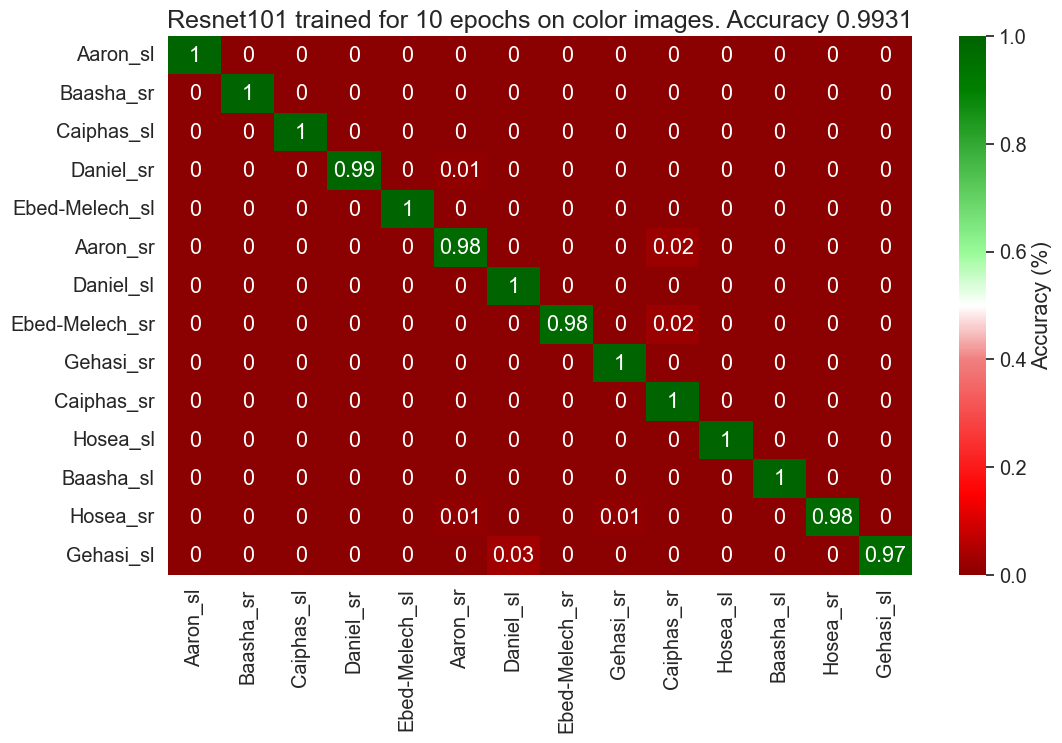

In [132]:
from  matplotlib.colors import LinearSegmentedColormap
#cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
plt.clf()

c = ["darkred","red","lightcoral","white", "palegreen","green","darkgreen"]
v = [0,.15,.4,.5,0.6,.9,1.]
l = list(zip(v,c))
cmap=LinearSegmentedColormap.from_list('rg',l, N=256)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(np.round(cf_matrix / np.sum(cf_matrix, axis=1), 2), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
plt.title(title + '. Accuracy ' + str(round(np.average(np.array(res)), 4)), fontsize = 18)
sn.set(font_scale=1.3)
sn.heatmap(df_cm, annot=True, cmap = cmap, cbar_kws={'label': 'Accuracy (%)'})
plt.savefig(os.path.join(save_path, title + '.png'), dpi=300, bbox_inches = "tight")

<Figure size 640x480 with 0 Axes>

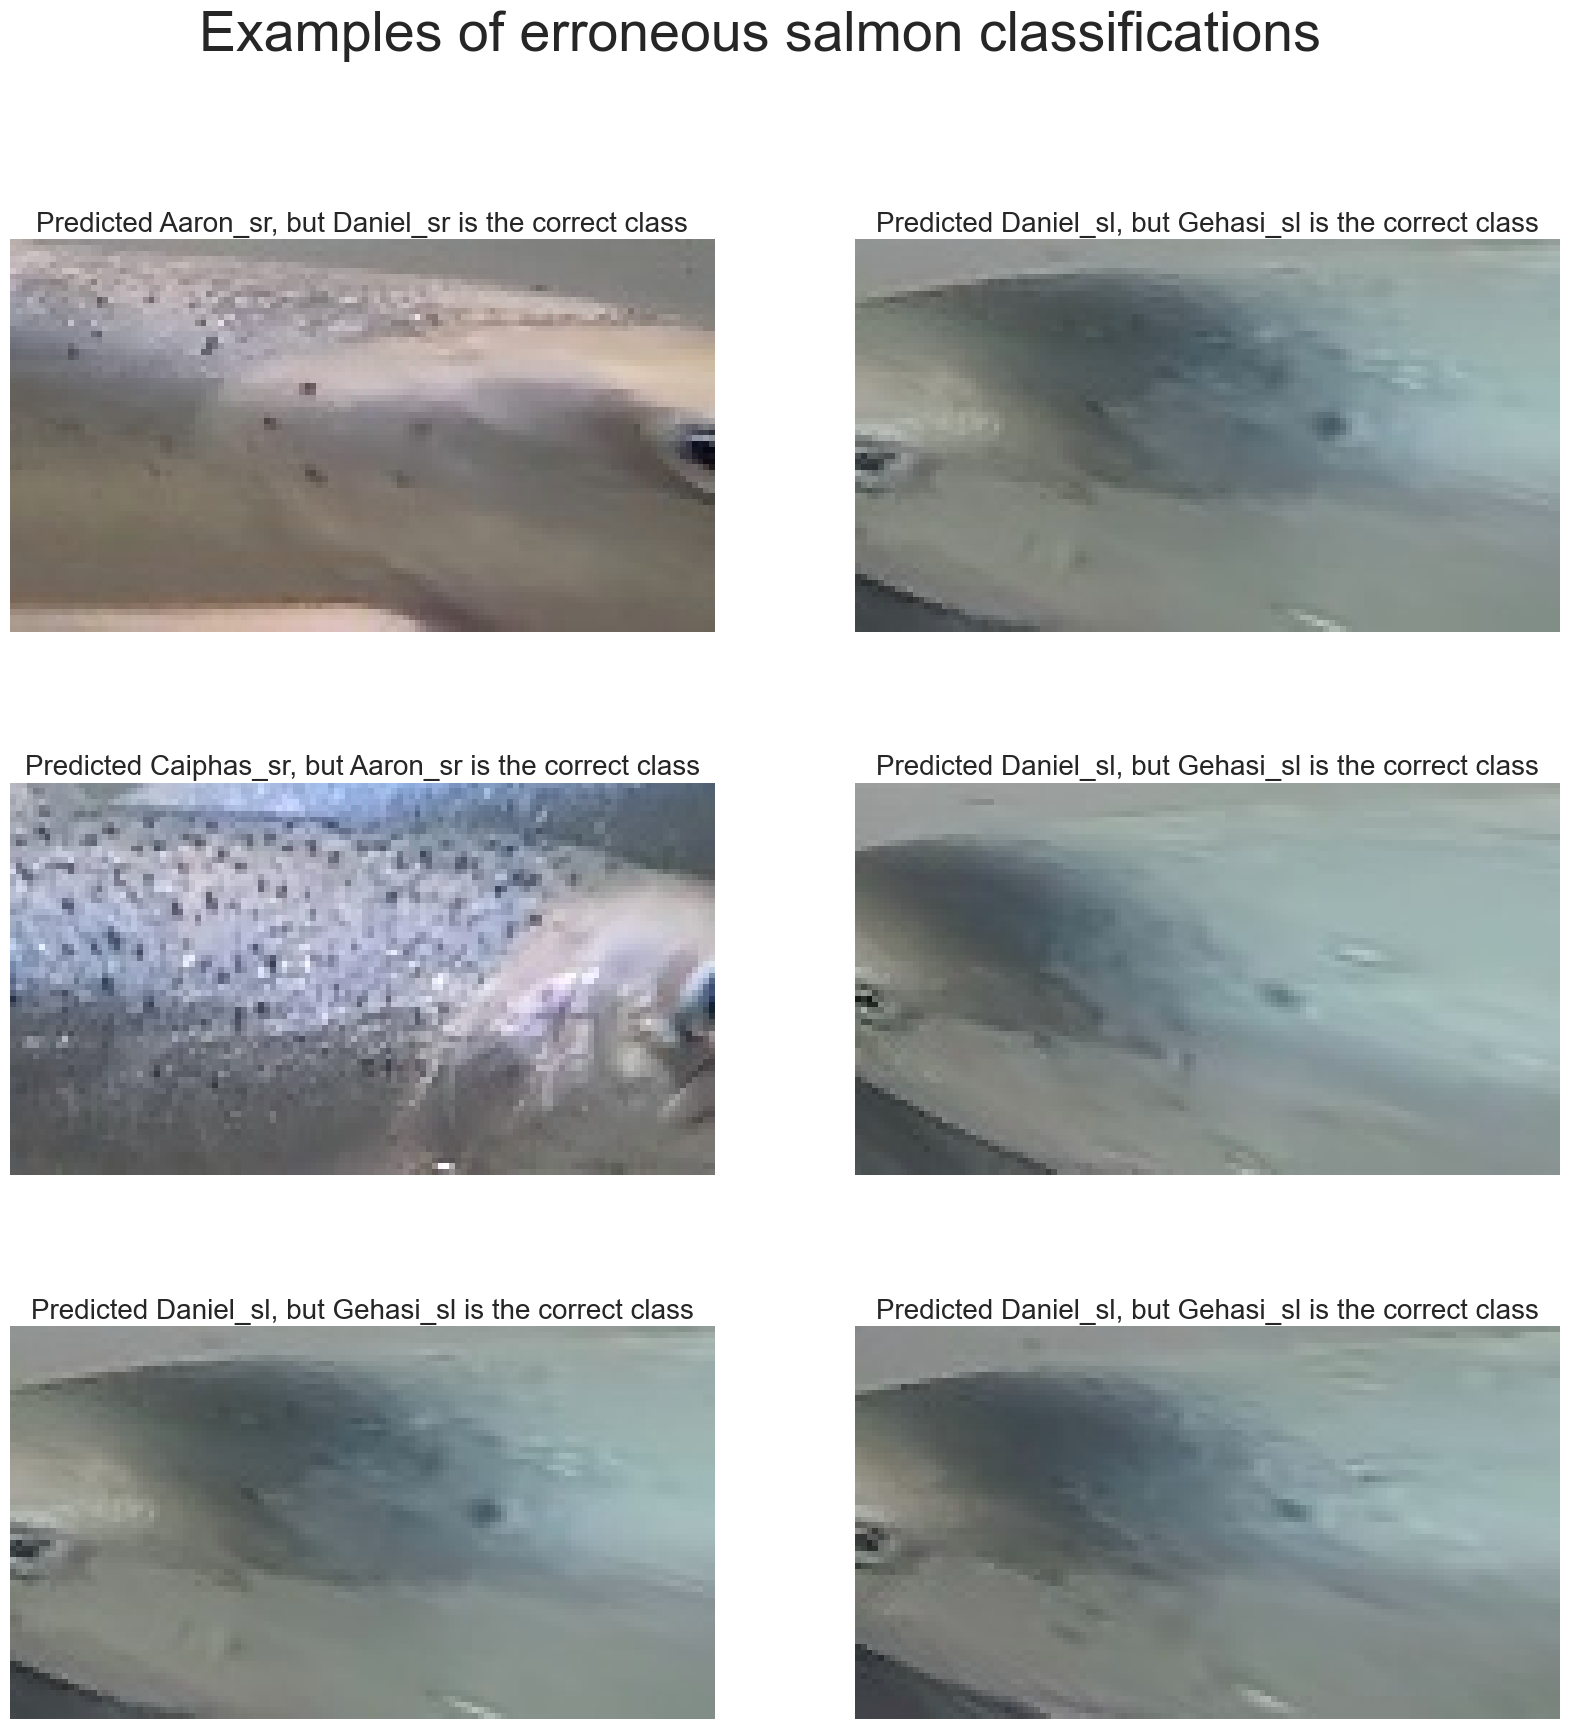

In [181]:
# Print wrong predictions
plt.clf()

n_col = 2
n_row = 3
sample = random.sample(range(len(err_img)), n_col*n_row)

fig, ax = plt.subplots(n_row, n_col ,figsize=(20, 20))
fig.suptitle('Examples of erroneous salmon classifications', fontsize = 40)
for i in range(n_row):
    for j in range(n_col):
        s_idx = sample[i + j*(n_row-1)]
        ax[i][j].imshow(cv2.cvtColor(err_img[s_idx][:,:,:], cv2.COLOR_BGR2RGB))
        ax[i][j].grid(None)
        ax[i][j].set_title('Predicted ' + m.CLASSES_MAP_T9[int(err_pred[s_idx][0])] + ', but ' +  m.CLASSES_MAP_T9[int(err_pred[s_idx][1])] + ' is the correct class', fontdict = {'fontsize': 20})
        ax[i][j].axis('off')

Total convolutional layers: 100


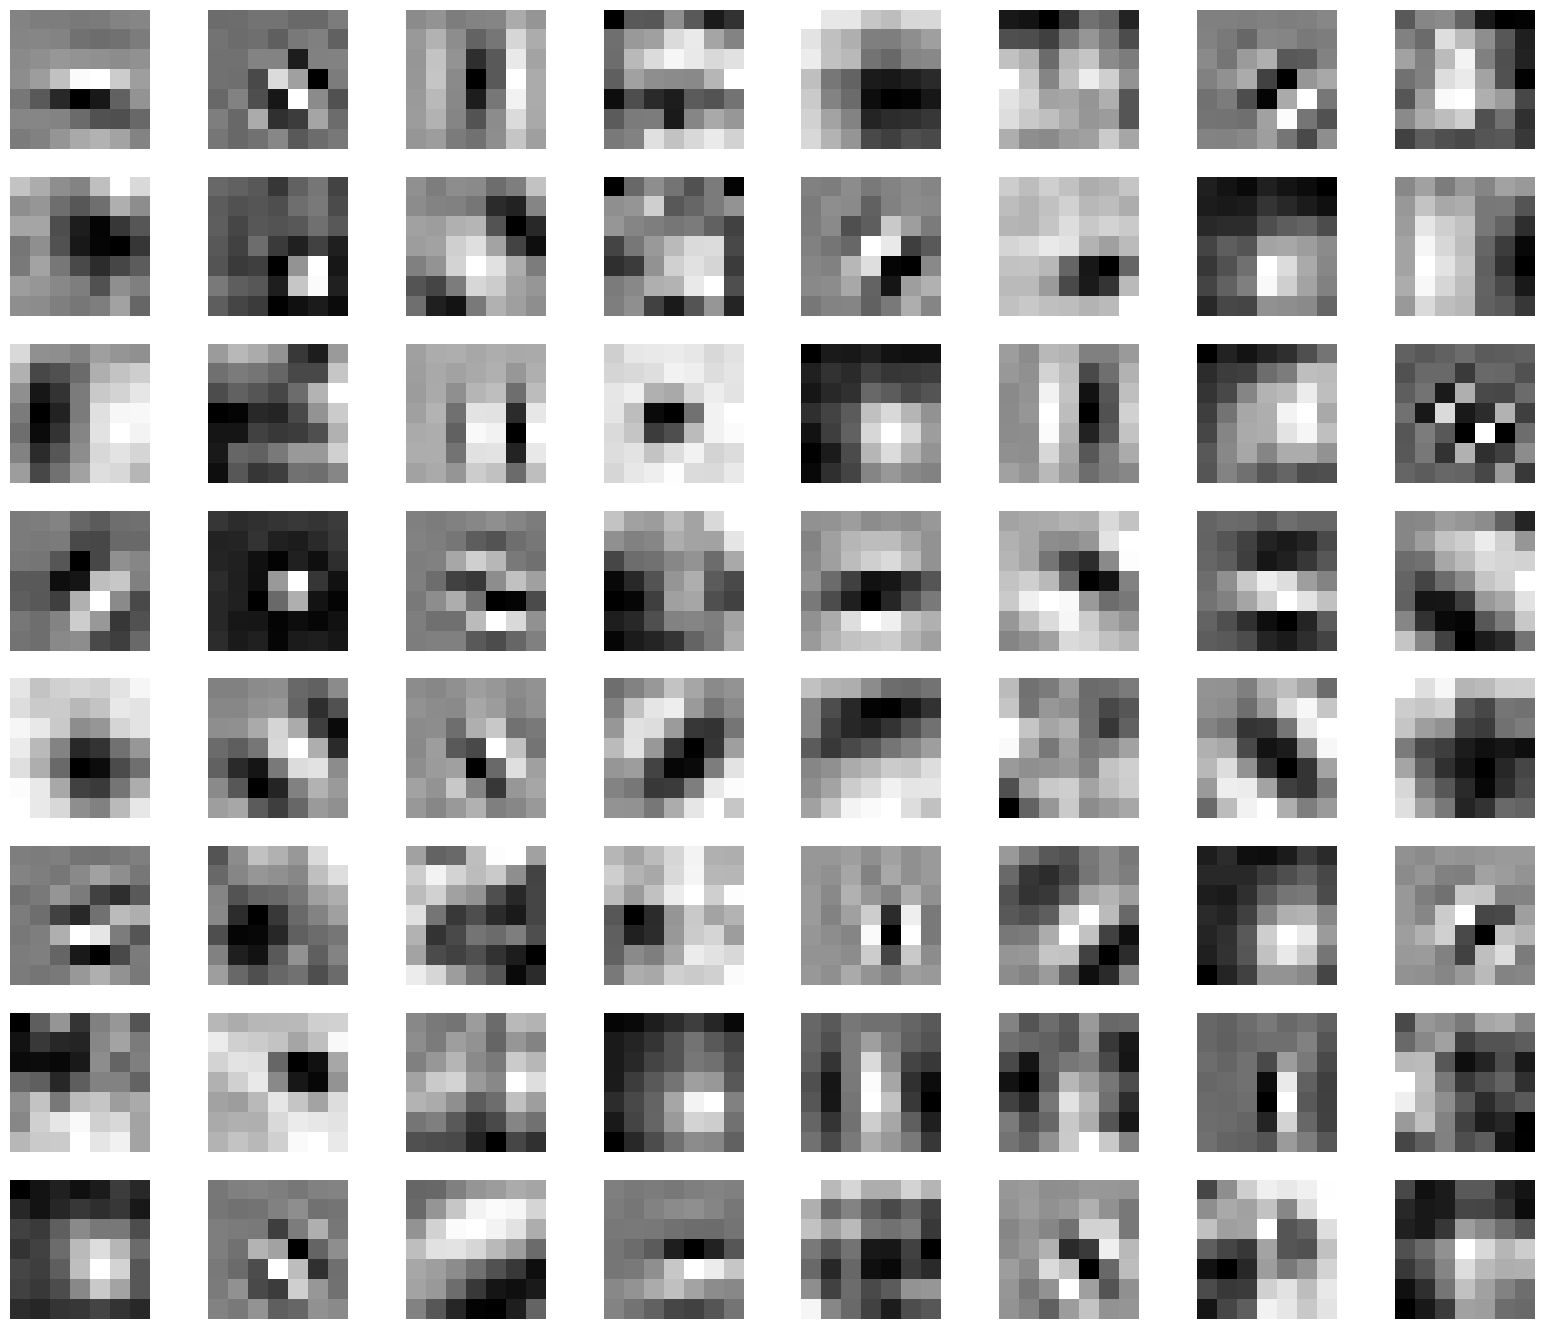

In [134]:
# Print network filters
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import cv2 as cv
import argparse
from torchvision import models, transforms

filter_num = 0
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list

# get all the model children as list
model_children = list(model.children())

# counter to keep count of the conv layers
counter = 0
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[filter_num]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()

11


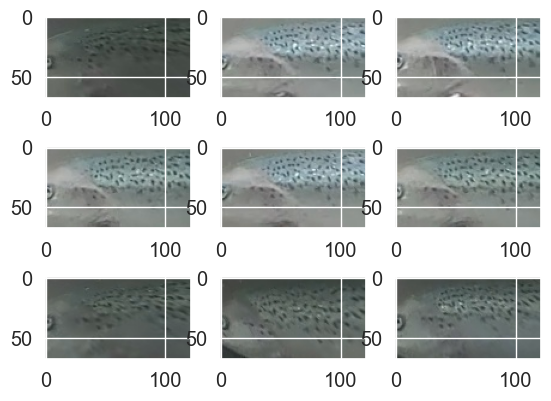

In [135]:
# Print nine torax images from one class
cl = 12
cl_arr = []
n_cl = 9
# Plot from class
for d, t in data_loader_test_RGB:
    if len(cl_arr) > n_cl:
        break
    if d.shape[0] == m.BATCH_SIZE:
        pred = model(d.squeeze(0))
        pred_np = np.argmax(softmax(pred.detach().cpu().numpy()), axis=1)
        gt = t.detach().cpu().numpy()
        for i in range(len(gt)):
            if gt[i] == cl:
                cl_arr.append(cv2.cvtColor(d[i].squeeze(0).detach().cpu().numpy().transpose(1,2,0), cv2.COLOR_BGR2RGB))
fig, ax = plt.subplots(3,3)
print(len(cl_arr))
for i in range(3):
    for j in range(3):
        ax[i][j].imshow(cl_arr[j + i*3][:,:,:])
# 2t_t9 10660.16

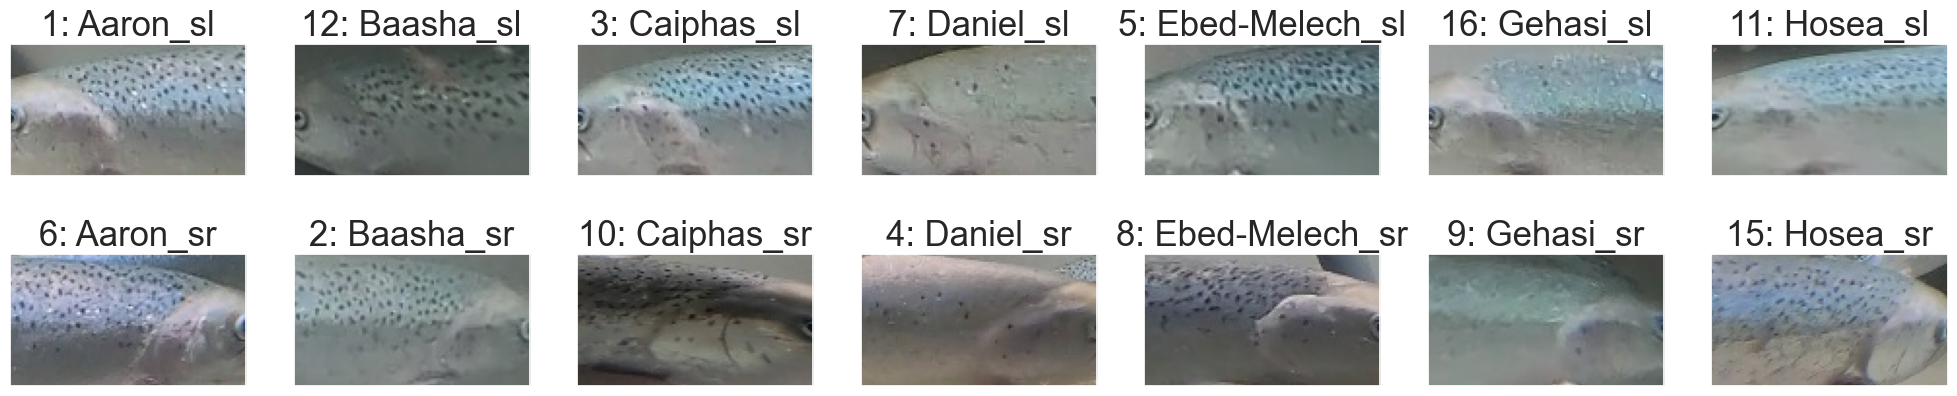

In [197]:
import random
random.seed(10)

# Print one fish from each class
imgs = []
clses = []
curr_clas = 1

# Plot from class
for d, t in data_loader_test_RGB:
    if curr_clas > 16:
        break
    if d.shape[0] == m.BATCH_SIZE:
        gt = t.detach().cpu().numpy()
        for i in range(len(gt)):
            if gt[i] == curr_clas:
                imgs.append(d[i].squeeze(0).detach().cpu().numpy().transpose(1,2,0))
                clses.append(gt[i])
                curr_clas = curr_clas + 1
            if curr_clas == 13:
                curr_clas = 15

sort_i = np.argsort(np.array(m.CLASSES_T9)[np.array(clses)])

nc = 7
nr = 2
fig, ax = plt.subplots(nr,nc, figsize=(25, 5))
for cnt, i in zip(range(len(sort_i)), sort_i):
        row = cnt % nr
        col = cnt // nr
        ax[row][col].imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))
        ax[row][col].get_xaxis().set_visible(False)
        ax[row][col].get_yaxis().set_visible(False)
        ax[row][col].set_title(str(clses[i]) + ': ' + m.CLASSES_T9[int(clses[i])], fontsize = 25)
        